In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import round
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import MinMaxScaler 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

spark = (SparkSession.builder
         .appName("Home-Credit")
         .config("spark.driver.memory", "5g")
         .config("spark.executor.memory", "4g")  
         .master("local[*]")  
         .getOrCreate())

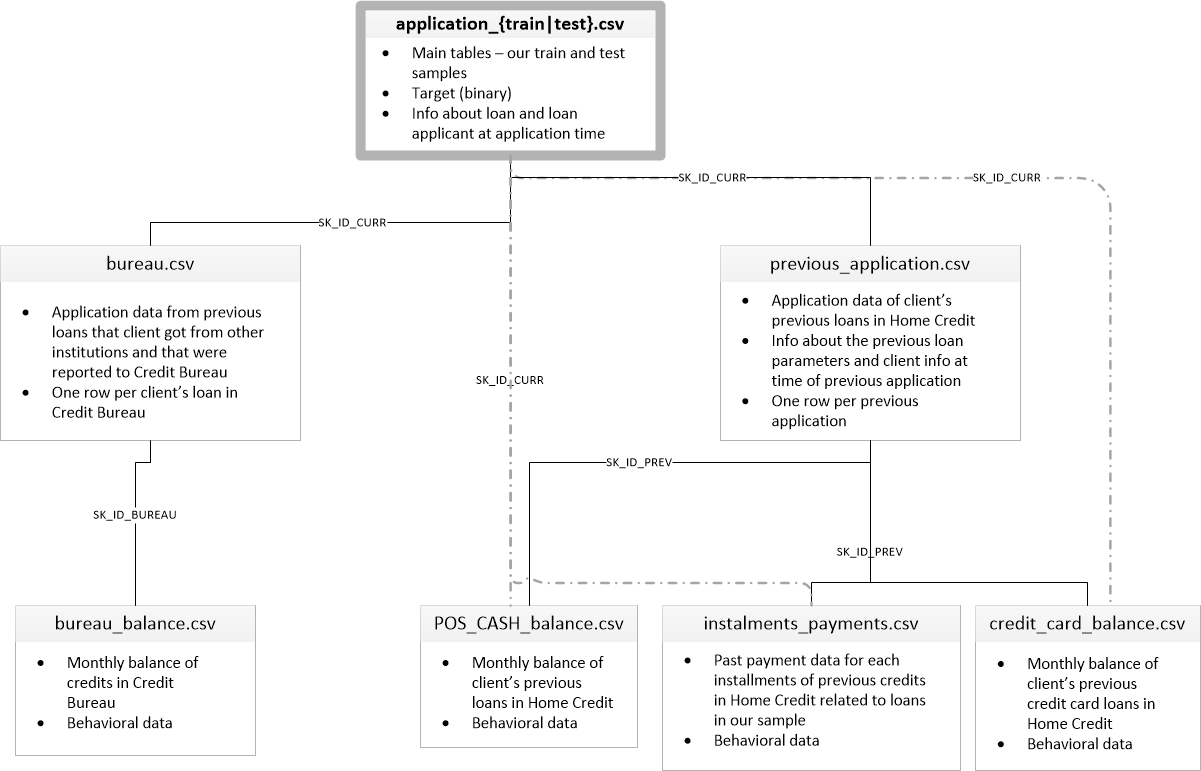

I, Tiền sử lí dữ liệu

1, Khảo sát dữ liệu

Danh sách các file dữ liệu

In [3]:
import os

os.listdir('./data')

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

Traning data

In [4]:
app_train = spark.read.csv("./data/application_train.csv", header=True, inferSchema=True)
app_train.show(5)
print("The data contain %d records." % app_train.count())
app_train.printSchema()
app_train.describe().show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------

Other data

In [5]:
prev_app = spark.read.csv("./data/previous_application.csv", header=True, inferSchema=True)
installments = spark.read.csv("./data/installments_payments.csv", header=True, inferSchema=True)
pos = spark.read.csv("./data/POS_CASH_balance.csv", header=True, inferSchema=True)
bureau = spark.read.csv("./data/bureau.csv", header=True, inferSchema=True)
bureau_bal = spark.read.csv("./data/bureau_balance.csv", header=True, inferSchema=True)
credit_card = spark.read.csv("./data/credit_card_balance.csv", header=True, inferSchema=True)

In [6]:
print("The data previous_application.csv contain %d records." % prev_app.count())
print("The data installments_payments.csv contain %d records." % installments.count())
print("The data POS_CASH_balance.csv contain %d records." % pos.count())
print("The data bureau.csv contain %d records." % bureau.count())
print("The data bureau_balance.csv contain %d records." % bureau_bal.count())
print("The data credit_card_balance contain %d records." % credit_card.count())

The data previous_application.csv contain 1670214 records.
The data installments_payments.csv contain 13605401 records.
The data POS_CASH_balance.csv contain 10001358 records.
The data bureau.csv contain 1716428 records.
The data bureau_balance.csv contain 27299925 records.
The data credit_card_balance contain 3840312 records.


Giá trị cần hướng tới sẽ là cột TARGET và biến này sẽ thống kê các giá trị Repaid và Not Repaid

+------+------+
|TARGET| count|
+------+------+
|     1| 24825|
|     0|282686|
+------+------+



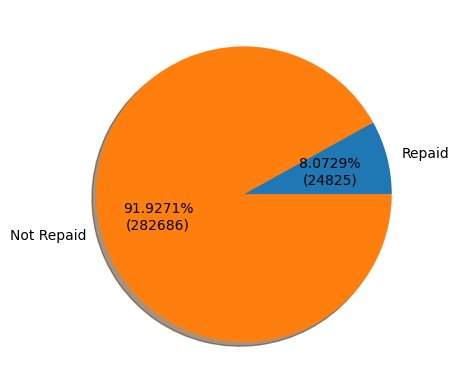

In [7]:
def my_fmt(x, total):
    return '{:.4f}%\n({:.0f})'.format(x, total * x / 100)

targetValue = app_train.groupBy('TARGET').count()
targetValue.show()

x = np.array(['Repaid', 'Not Repaid'])
y = np.array([e[0] for e in targetValue.select('count').collect()])

total = np.sum(y)
def autopct_func(pct):
    return my_fmt(pct, total)

# Plot pie chart
plt.pie(y, labels=x, autopct=autopct_func, shadow=True)
plt.show()


 Hiện tượng mất cân bằng khi nhóm thiểu số chỉ chiếm 8.07% và nhóm đa số chiếm tới 91.93%

In [8]:
columns = app_train.columns
null_counts = app_train.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in columns])
null_counts.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

2, Sử lí ngoại lai

In [9]:
app_train.select('AMT_INCOME_TOTAL').describe().show()

+-------+-----------------+
|summary| AMT_INCOME_TOTAL|
+-------+-----------------+
|  count|           307511|
|   mean|168797.9192969845|
| stddev| 237123.146278856|
|    min|          25650.0|
|    max|           1.17E8|
+-------+-----------------+



Giá trị cao nhất tận 117Tr trong khi giá trị trung bình chỉ có 168797 nên ta có thể nhận ra app_train có rất nhiều giá trị ngoại lại

Match data

In [10]:
# Bureau aggregation
agg_bureau = bureau.groupBy('SK_ID_CURR').agg(
    F.sum(F.when(bureau['CREDIT_ACTIVE'] == 'Active', 1).otherwise(0)).alias('num_active_loans'),
    F.sum('CNT_CREDIT_PROLONG').alias('sum_credit_prolong'),
    F.count('CREDIT_ACTIVE').alias('num_past_loans'),
    F.mean('CREDIT_DAY_OVERDUE').alias('avg_days_overdue'),
    F.sum('AMT_CREDIT_SUM_LIMIT').alias('total_credit_limit'),
    F.mean('AMT_ANNUITY').alias('avg_annuity')
)

In [11]:
# POS aggregation
agg_pos = pos.groupBy('SK_ID_CURR').agg(
    F.sum(F.when(pos['SK_DPD'] > 30, 1).otherwise(0)).alias('late_payment_freq'),
    F.sum('SK_DPD').alias('DPD_sum'),
    F.mean('CNT_INSTALMENT').alias('avg_installment_duration'),
    F.max('CNT_INSTALMENT_FUTURE').alias('max_installment_left')
)

In [12]:
# Credit Card aggregation
agg_cc = credit_card.groupBy('SK_ID_CURR').agg(
    F.mean('AMT_BALANCE').alias('avg_balance'),
    F.sum('AMT_DRAWINGS_ATM_CURRENT').alias('atm_drawings'),
    F.sum('AMT_DRAWINGS_POS_CURRENT').alias('pos_drawings'),
    F.sum('AMT_DRAWINGS_CURRENT').alias('all_drawings'),
    F.sum('AMT_CREDIT_LIMIT_ACTUAL').alias('credit_limit')
)
agg_cc = agg_cc.withColumn('atm_drawings', (agg_cc['atm_drawings'] / (agg_cc['all_drawings'] + 0.001)) * 100)
agg_cc = agg_cc.withColumn('pos_drawings', (agg_cc['pos_drawings'] / (agg_cc['all_drawings'] + 0.001)) * 100)
agg_cc = agg_cc.withColumn('credit_usage', (agg_cc['all_drawings'] / (agg_cc['credit_limit'] + 0.001)) * 100)


In [13]:
# Previous Application aggregation
prev_app = prev_app.withColumn('NAME_CLIENT_TYPE', F.when(prev_app['NAME_CLIENT_TYPE'] == 'XNA', None).otherwise(prev_app['NAME_CLIENT_TYPE']))
prev_app = prev_app.withColumn('NAME_YIELD_GROUP', F.when(prev_app['NAME_YIELD_GROUP'] == 'XNA', None).otherwise(prev_app['NAME_YIELD_GROUP']))

agg_pa = prev_app.groupBy('SK_ID_CURR').agg(
    F.sum('AMT_CREDIT').alias('sum_credit_prev'),
    F.sum('AMT_APPLICATION').alias('app_min_credit'),
    F.sum('AMT_DOWN_PAYMENT').alias('down_pay'),
    F.max('DAYS_DECISION').alias('days_decision'),
    F.sum('NFLAG_INSURED_ON_APPROVAL').alias('req_insurance')
)

agg_pa = agg_pa.withColumn('app_min_credit', agg_pa['app_min_credit'] - agg_pa['sum_credit_prev'])
agg_pa = agg_pa.withColumn('downp_percent', (agg_pa['down_pay'] / agg_pa['sum_credit_prev']) * 100)


In [14]:
# Installments aggregation
agg_inst = installments.groupBy('SK_ID_CURR').agg(
    F.mean('DAYS_ENTRY_PAYMENT').alias('paid_on'),
    F.mean('DAYS_INSTALMENT').alias('pay_due'),
    F.sum('AMT_PAYMENT').alias('amt_paid'),
    F.sum('AMT_INSTALMENT').alias('amt_due')
)

agg_inst = agg_inst.withColumn('amt_extra', agg_inst['amt_paid'] - agg_inst['amt_due'])
agg_inst = agg_inst.withColumn('days_delay', agg_inst['paid_on'] - agg_inst['pay_due'])
agg_inst = agg_inst.drop('amt_paid', 'amt_due', 'pay_due', 'paid_on')


In [15]:
# Merging aggregated data 
app_train = app_train.join(agg_bureau, on='SK_ID_CURR', how='left')
app_train = app_train.join(agg_pos, on='SK_ID_CURR', how='left')
app_train = app_train.join(agg_cc, on='SK_ID_CURR', how='left')
app_train = app_train.join(agg_pa, on='SK_ID_CURR', how='left')
app_train = app_train.join(agg_inst, on='SK_ID_CURR', how='left')

app_train.show()


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-------------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----

In [16]:
print("The data train contain %d records." % app_train.count())

The data train contain 307511 records.


xoá trùng 

In [17]:
def find_duplicate_columns(df):
    col_names = df.columns
    duplicate_cols = [col for col in col_names if col_names.count(col) > 1]
    return list(set(duplicate_cols)) 

duplicate_columns = find_duplicate_columns(app_train)

app_train = app_train.drop(*duplicate_columns)

app_train.show()
app_train.printSchema()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-------------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----

Xoá các cột có trên 50% null

In [18]:

def bad_cols(df, threshold=0.5):

    missing_rate = df.select([(F.sum(F.col(c).isNull().cast("int")) / F.count(F.col(c))).alias(c) for c in df.columns])


    missing_rate_row = missing_rate.collect()[0].asDict()


    bad_columns = [col_name for col_name, rate in missing_rate_row.items() if rate > threshold]
    return bad_columns


bad_columns = bad_cols(app_train)

app_train = app_train.drop(*bad_columns)


app_train.show()
app_train.printSchema()


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-------------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+------

Split Data

In [19]:
(trainingData, testData) = app_train.randomSplit([0.8, 0.2], seed=42)
trainingData.show()
testData.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-------------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---

Oversampling

In [20]:
positive_class = trainingData.filter(F.col("TARGET") == 1)
negative_class = trainingData.filter(F.col("TARGET") == 0)

positive_count = positive_class.count()
oversampled_positive_class = positive_class.sample(withReplacement=True, fraction=(negative_class.count() / positive_count))

trainingData = negative_class.union(oversampled_positive_class)
positive_class.show()
negative_class.show()
trainingData.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+--------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---

Undersampling

In [21]:
negative_count = negative_class.count()

undersampled_negative_class = negative_class.sample(withReplacement=False, fraction=(positive_count / negative_count))

trainingData = positive_class.union(undersampled_negative_class)
trainingData.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+--------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---

3, Xử lí missing value

In [22]:
string_columns = [col for col, dtype in trainingData.dtypes if dtype == 'string']

for col in string_columns:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid="keep")
    trainingData = indexer.fit(trainingData).transform(trainingData)
    testData = indexer.fit(testData).transform(testData)

columns = [col for col in trainingData.columns if col != 'SK_ID_CURR' and col != 'TARGET' and col not in string_columns]

indexed_columns = [f"{col}_indexed" for col in string_columns]
columns += indexed_columns

for col in columns:
    mean_value_train = trainingData.select(F.mean(col)).collect()[0][0]
    mean_value_test = trainingData.select(F.mean(col)).collect()[0][0]
    if mean_value_train is not None:
        trainingData = trainingData.fillna({col: mean_value_train})
    if mean_value_test is not None:
        testData = testData.fillna({col: mean_value_test})


Chuẩn bị dữ liệu

In [23]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
app_train_vector = assembler.transform(trainingData)
app_test_vector = assembler.transform(testData)

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model_train = scaler.fit(app_train_vector)
scaler_model_test = scaler.fit(app_test_vector)
app_train_scaled = scaler_model_train.transform(app_train_vector)
app_test_scaled = scaler_model_test.transform(app_test_vector)

app_train_scaled.select("scaledFeatures").show()
app_test_scaled.select("scaledFeatures").show()

+--------------------+
|      scaledFeatures|
+--------------------+
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[0,1,2,3,4,5...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
+--------------------+
only showing top 20 rows

+--------------------+
|      scaledFeatures|
+--------------------+
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[0,1,2,3,4,5...|
|(100,[0,1,2,3,4,5...|
|(100,[0,1,2,3,4,5...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1,2,3,4,5,6...|
|(100,[1

II, Modeling

1, Logistic Regression

Area under ROC: 0.6448952575585589
Accuracy = 0.84
Precision: 0.8871899163746378
Recall: 0.8392032994010016
F1 Score: 0.8597980959935311
+----------+------+----------+
|SK_ID_CURR|TARGET|prediction|
+----------+------+----------+
|    100035|     0|       0.0|
|    100101|     0|       0.0|
|    100108|     0|       0.0|
|    100178|     0|       0.0|
|    100274|     0|       0.0|
|    100390|     0|       0.0|
|    100453|     0|       0.0|
|    100570|     0|       0.0|
|    100691|     0|       0.0|
|    100716|     0|       0.0|
|    100771|     0|       0.0|
|    100774|     0|       0.0|
|    100787|     0|       0.0|
|    100803|     0|       0.0|
|    100895|     0|       0.0|
|    100942|     0|       0.0|
|    101110|     0|       0.0|
|    101563|     0|       0.0|
|    101734|     0|       0.0|
|    101775|     0|       0.0|
+----------+------+----------+
only showing top 20 rows



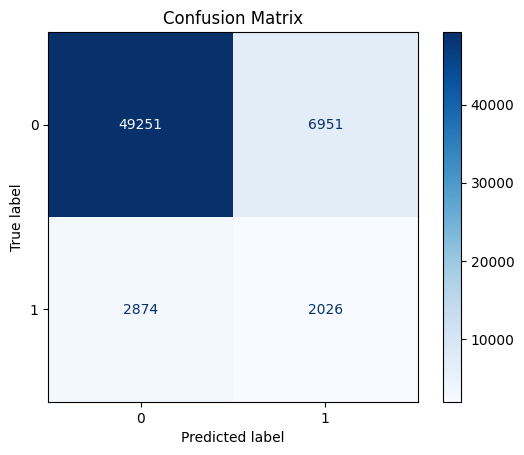

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay


lr = LogisticRegression(featuresCol='scaledFeatures', labelCol="TARGET")
lr_model = lr.fit(app_train_scaled)

predictionsTest = lr_model.transform(app_test_scaled)

evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictionsTest)
print("Area under ROC:", roc_auc)

evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsTest)
print("Accuracy = {:.2f}".format(accuracy))

precision_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
print("Precision:", precision_evaluator.evaluate(predictionsTest))

recall_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")
print("Recall:", recall_evaluator.evaluate(predictionsTest))

F1_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
print("F1 Score:", F1_evaluator.evaluate(predictionsTest))

predictionsTest = predictionsTest.withColumn("prediction_class", when(predictionsTest["prediction"] >= 0.5, 1).otherwise(0))
predictionsTest.select("SK_ID_CURR", "TARGET", "prediction").show()
confusion_matrix = predictionsTest.groupBy("TARGET", "prediction_class").count().orderBy("TARGET", "prediction_class")

tp = predictionsTest.filter((F.col("TARGET") == 1) & (F.col("prediction_class") == 1)).count()
tn = predictionsTest.filter((F.col("TARGET") == 0) & (F.col("prediction_class") == 0)).count()
fp = predictionsTest.filter((F.col("TARGET") == 0) & (F.col("prediction_class") == 1)).count()
fn = predictionsTest.filter((F.col("TARGET") == 1) & (F.col("prediction_class") == 0)).count()

confusion_matrix = [[tn, fp],
                    [fn, tp]]

cm_display = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix), display_labels=[0, 1])

cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

2, Random Forest Regression

Area under ROC: 0.6682211468979606
Accuracy = 0.70
Precision: 0.8922848187425304
Recall: 0.7001407482570129
F1 Score: 0.7675395814878433
+----------+------+----------+
|SK_ID_CURR|TARGET|prediction|
+----------+------+----------+
|    100035|     0|       0.0|
|    100101|     0|       0.0|
|    100108|     0|       0.0|
|    100178|     0|       0.0|
|    100274|     0|       0.0|
|    100390|     0|       0.0|
|    100453|     0|       0.0|
|    100570|     0|       0.0|
|    100691|     0|       1.0|
|    100716|     0|       0.0|
|    100771|     0|       0.0|
|    100774|     0|       0.0|
|    100787|     0|       0.0|
|    100803|     0|       1.0|
|    100895|     0|       0.0|
|    100942|     0|       0.0|
|    101110|     0|       0.0|
|    101563|     0|       0.0|
|    101734|     0|       0.0|
|    101775|     0|       1.0|
+----------+------+----------+
only showing top 20 rows



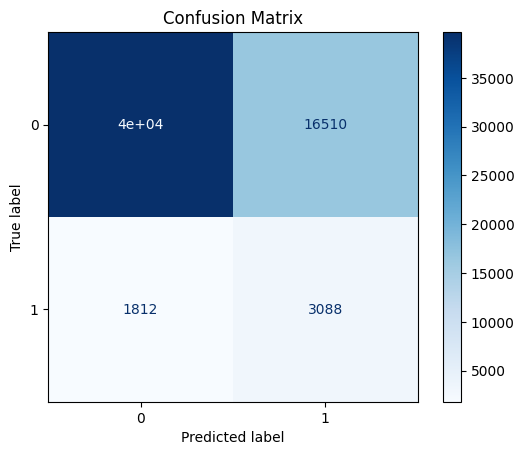

In [26]:
from pyspark.ml.classification import RandomForestClassifier

rr = RandomForestClassifier(featuresCol='scaledFeatures', labelCol="TARGET", numTrees=500)
rr_model = rr.fit(app_train_scaled)

predictionsTest = rr_model.transform(app_test_scaled)

evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictionsTest)
print("Area under ROC:", roc_auc)


evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsTest)
print("Accuracy = {:.2f}".format(accuracy))

precision_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
print("Precision:", precision_evaluator.evaluate(predictionsTest))

recall_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")
print("Recall:", recall_evaluator.evaluate(predictionsTest))

F1_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
print("F1 Score:", F1_evaluator.evaluate(predictionsTest))

predictionsTest = predictionsTest.withColumn("prediction_class", when(predictionsTest["prediction"] >= 0.5, 1).otherwise(0))
predictionsTest.select("SK_ID_CURR", "TARGET", "prediction").show()
confusion_matrix = predictionsTest.groupBy("TARGET", "prediction_class").count().orderBy("TARGET", "prediction_class")

tp = predictionsTest.filter((F.col("TARGET") == 1) & (F.col("prediction_class") == 1)).count()
tn = predictionsTest.filter((F.col("TARGET") == 0) & (F.col("prediction_class") == 0)).count()
fp = predictionsTest.filter((F.col("TARGET") == 0) & (F.col("prediction_class") == 1)).count()
fn = predictionsTest.filter((F.col("TARGET") == 1) & (F.col("prediction_class") == 0)).count()

confusion_matrix = [[tn, fp],
                    [fn, tp]]

cm_display = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix), display_labels=[0, 1])

cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

4, Gradient-Boosted Trees Regression

Area under ROC: 0.6757489420450576
Accuracy = 0.71
Precision: 0.8938195280030699
Recall: 0.7091911885044679
F1 Score: 0.774197872364915
+----------+------+----------+
|SK_ID_CURR|TARGET|prediction|
+----------+------+----------+
|    100035|     0|       0.0|
|    100101|     0|       0.0|
|    100108|     0|       0.0|
|    100178|     0|       0.0|
|    100274|     0|       0.0|
|    100390|     0|       0.0|
|    100453|     0|       0.0|
|    100570|     0|       0.0|
|    100691|     0|       1.0|
|    100716|     0|       0.0|
|    100771|     0|       1.0|
|    100774|     0|       0.0|
|    100787|     0|       0.0|
|    100803|     0|       1.0|
|    100895|     0|       0.0|
|    100942|     0|       0.0|
|    101110|     0|       0.0|
|    101563|     0|       0.0|
|    101734|     0|       0.0|
|    101775|     0|       0.0|
+----------+------+----------+
only showing top 20 rows



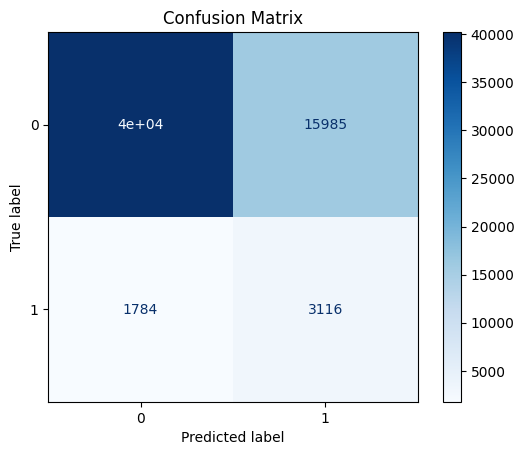

In [27]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol='scaledFeatures', labelCol="TARGET", maxIter=20)
gb_model = gb.fit(app_train_scaled)

predictionsTest = gb_model.transform(app_test_scaled)

evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictionsTest)
print("Area under ROC:", roc_auc)

evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionsTest)
print("Accuracy = {:.2f}".format(accuracy))

precision_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
print("Precision:", precision_evaluator.evaluate(predictionsTest))

recall_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")
print("Recall:", recall_evaluator.evaluate(predictionsTest))

F1_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
print("F1 Score:", F1_evaluator.evaluate(predictionsTest))

predictionsTest = predictionsTest.withColumn("prediction_class", when(predictionsTest["prediction"] >= 0.5, 1).otherwise(0))
predictionsTest.select("SK_ID_CURR", "TARGET", "prediction").show()
confusion_matrix = predictionsTest.groupBy("TARGET", "prediction_class").count().orderBy("TARGET", "prediction_class")

tp = predictionsTest.filter((F.col("TARGET") == 1) & (F.col("prediction_class") == 1)).count()
tn = predictionsTest.filter((F.col("TARGET") == 0) & (F.col("prediction_class") == 0)).count()
fp = predictionsTest.filter((F.col("TARGET") == 0) & (F.col("prediction_class") == 1)).count()
fn = predictionsTest.filter((F.col("TARGET") == 1) & (F.col("prediction_class") == 0)).count()

confusion_matrix = [[tn, fp],
                    [fn, tp]]

cm_display = ConfusionMatrixDisplay(confusion_matrix=np.array(confusion_matrix), display_labels=[0, 1])

cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()